In [ ]:
import pandas as pd # For transforming JSON data into a pandas dataframe

In [4]:
# B.1.1: Define the maximum length for a sequence
MAX_LEN = 40


# B.1.4: CSV path
csv_path = (r'updated_historical_task_data.csv')

# B.1.5: Load the dataset from CSV
df = pd.read_csv(csv_path)

In [5]:
pd.set_option('display.max_columns', None)
print(df[:10])


# Display train and test num rows
print(f'No. of rows: {len(df)}')

       id  can_pivot                      date_created  \
0  854260      False  2024-08-07 01:42:01.651736+00:00   
1  846405      False  2024-08-01 11:25:47.734743+00:00   
2  850928       True  2024-08-05 03:26:43.010811+00:00   
3  854486      False  2024-08-07 04:53:18.290521+00:00   
4  854486      False  2024-08-07 04:53:18.290521+00:00   
5  854486      False  2024-08-07 04:53:18.290521+00:00   
6  831866      False  2024-07-24 01:20:58.305063+00:00   
7  831566      False  2024-07-23 19:57:20.597660+00:00   
8  806180      False  2024-07-07 02:38:41.285841+00:00   
9  806179      False  2024-07-07 02:38:30.102138+00:00   

                    date_due description                           done_at  \
0                        NaN         NaN  2024-08-07 05:41:01.145415+00:00   
1  2024-08-01 11:23:00+00:00         NaN  2024-08-07 05:40:18.404492+00:00   
2  2024-08-11 15:59:00+00:00         NaN  2024-08-07 05:40:14.839560+00:00   
3  2024-08-07 04:45:00+00:00         NaN  2024-08

In [6]:
# Frequency distribution of 'task_duration_hours'
frequency_distribution = df['task_duration_hours'].value_counts().sort_index()

# Display the result
print(frequency_distribution)

task_duration_hours
0.000320        1
0.000325        1
0.000364        1
0.000368        1
0.000388        1
               ..
17409.218828    1
17409.218934    1
19297.824030    1
19297.830642    1
19459.623471    1
Name: count, Length: 28522, dtype: int64


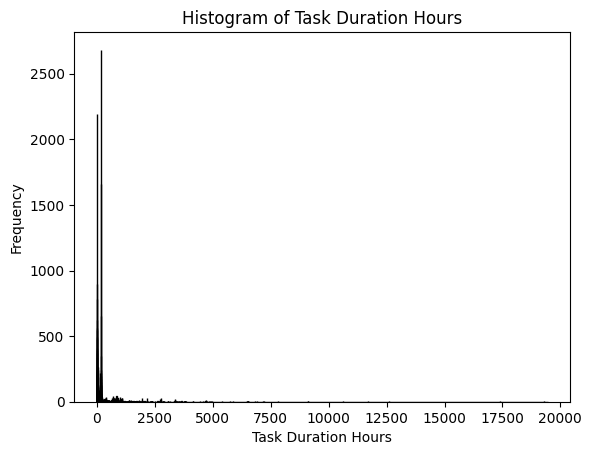

In [7]:
import matplotlib.pyplot as plt

# Plot histogram of 'task_duration_hours' from 0 to the maximum value
plt.hist(df['task_duration_hours'], bins=range(0, int(df['task_duration_hours'].max()) + 2), edgecolor='black')

# Add labels and title
plt.xlabel('Task Duration Hours')
plt.ylabel('Frequency')
plt.title('Histogram of Task Duration Hours')

# Show the plot
plt.show()

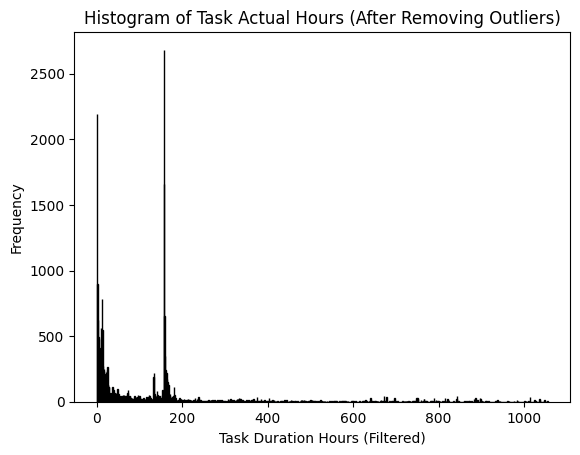

In [8]:
# Remove values greater than the 95th percentile
upper_limit = df['task_duration_hours'].quantile(0.95)
df_filtered = df[(df['task_duration_hours'] <= upper_limit) & (df['task_duration_hours'] > 0)]

# Plot the histogram after filtering out outliers
plt.hist(df_filtered['task_duration_hours'], bins=range(0, int(df_filtered['task_duration_hours'].max()) + 2), edgecolor='black')

# Add labels and title
plt.xlabel('Task Duration Hours (Filtered)')
plt.ylabel('Frequency')
plt.title('Histogram of Task Actual Hours (After Removing Outliers)')

# Show the plot
plt.show()


In [9]:
# Number of rows before and after filtering
original_count = len(df)
filtered_count = len(df_filtered)

# Calculate how many were filtered out
filtered_out_count = original_count - filtered_count

# Display the result
print(f"Original count: {original_count}")
print(f"Filtered count: {filtered_count}")
print(f"Number of rows filtered out: {filtered_out_count}")


Original count: 29348
Filtered count: 27880
Number of rows filtered out: 1468


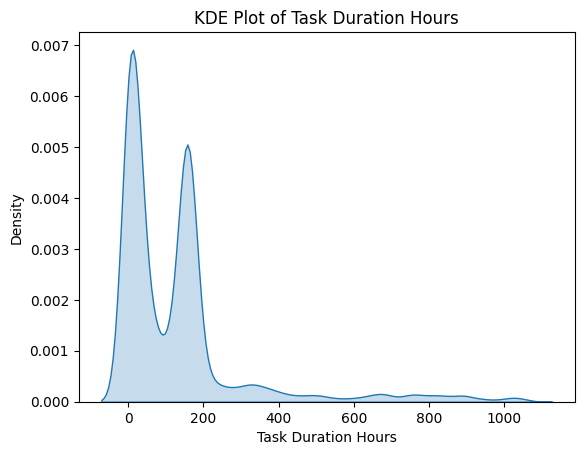

In [10]:
import seaborn as sns

# Plot KDE for task_actual_hours
sns.kdeplot(df_filtered['task_duration_hours'], fill=True)

# Add labels and title
plt.xlabel('Task Duration Hours')
plt.ylabel('Density')
plt.title('KDE Plot of Task Duration Hours')

# Show the plot
plt.show()


In [11]:
df = df_filtered

In [12]:
import torch
print(torch.cuda.is_available()) 

True


In [15]:
from transformers import AutoModel, AutoTokenizer
from datasets import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MiniLM tokenizer and model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name).to(device)

# Normalize Task Duration
mean_task_duration = df["task_duration_hours"].mean()
std_task_duration = df["task_duration_hours"].std()
df["task_duration_hours"] = (df["task_duration_hours"] - mean_task_duration) / std_task_duration

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Tokenize Data
def tokenize(batch):
    return tokenizer(batch["title"], padding="max_length", truncation=True, return_tensors="pt")

encoded_dataset = dataset.map(tokenize, batched=True)

# Extract input tensors
input_ids = torch.stack([torch.tensor(x) for x in encoded_dataset["input_ids"]]).squeeze(1).to(device)
attention_mask = torch.stack([torch.tensor(x) for x in encoded_dataset["attention_mask"]]).squeeze(1).to(device)
labels = torch.tensor(df["task_duration_hours"].values, dtype=torch.float32).to(device)

# Create PyTorch DataLoader
train_dataset = TensorDataset(input_ids, attention_mask, labels)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Define Regression Model
class MiniLMRegressor(nn.Module):
    def __init__(self, base_model):
        super(MiniLMRegressor, self).__init__()
        self.base_model = base_model
        self.regressor = nn.Linear(384, 1)  # MiniLM produces 384-dim embeddings

        # Unfreeze last 2 transformer layers
        for param in self.base_model.parameters():
            param.requires_grad = False  # Freeze all first
        for param in list(self.base_model.encoder.layer[-2:].parameters()):
            param.requires_grad = True  # Unfreeze last two layers

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]  # Use CLS token embedding
        return self.regressor(embeddings).squeeze(1)

# Initialize model and optimizer
model = MiniLMRegressor(base_model).to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-6, weight_decay=0.01)  # Lower LR
criterion = nn.HuberLoss()  # More robust loss function

# Training Loop
num_epochs = 15  # Increased from 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {epoch_loss / len(train_dataloader)}")

# Save Model
model_save_path = "/data/students/jeryl/OMNI/Omni"
torch.save(model.state_dict(), f"{model_save_path}/model.pt")
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")



Using device: cuda


Map:   0%|          | 0/27880 [00:00<?, ? examples/s]

Epoch 1/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.42it/s]


Epoch 1: Loss = 0.23506172020669755


Epoch 2/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.43it/s]


Epoch 2: Loss = 0.1909524748006293


Epoch 3/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.43it/s]


Epoch 3: Loss = 0.17760048601248568


Epoch 4/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.40it/s]


Epoch 4: Loss = 0.16948839947457695


Epoch 5/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.49it/s]


Epoch 5: Loss = 0.16085272606915207


Epoch 6/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.36it/s]


Epoch 6: Loss = 0.15394274862884


Epoch 7/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.45it/s]


Epoch 7: Loss = 0.14714742424731495


Epoch 8/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.42it/s]


Epoch 8: Loss = 0.1415490423696626


Epoch 9/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.36it/s]


Epoch 9: Loss = 0.13633629031692482


Epoch 10/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.38it/s]


Epoch 10: Loss = 0.13307305428632396


Epoch 11/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.41it/s]


Epoch 11: Loss = 0.12816922284491192


Epoch 12/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.34it/s]


Epoch 12: Loss = 0.1238775109309687


Epoch 13/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.35it/s]


Epoch 13: Loss = 0.1205073611558598


Epoch 14/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.30it/s]


Epoch 14: Loss = 0.11832172793918791


Epoch 15/15: 100%|██████████| 3485/3485 [00:58<00:00, 59.34it/s]


Epoch 15: Loss = 0.11493745023766172
Model saved to /data/students/jeryl/OMNI/Omni


In [16]:
# Load the base MiniLM model
base_model = AutoModel.from_pretrained(model_name).to(device)

# Load the fine-tuned regression model
model = MiniLMRegressor(base_model).to(device)
model.load_state_dict(torch.load("/data/students/jeryl/OMNI/Omni/model.pt"))
model.eval()  # Set model to evaluation mode

# Task names to predict duration
task_names = ["Refactor backend code", "Deploy machine learning model"]

# Tokenize inputs
inputs = tokenizer(task_names, padding=True, truncation=True, return_tensors="pt").to(device)

# Inference
with torch.no_grad():
    predictions = model(inputs["input_ids"], inputs["attention_mask"])

# Convert predictions back to original scale if normalized
mean_task_duration = 50  # Replace with actual mean from training
std_task_duration = 20   # Replace with actual std from training
predicted_durations = (predictions.cpu().numpy() * std_task_duration) + mean_task_duration

# Print results
for task, duration in zip(task_names, predicted_durations):
    print(f"Task: {task} -> Predicted Duration: {duration:.2f} hours")

Task: Refactor backend code -> Predicted Duration: 45.06 hours
Task: Deploy machine learning model -> Predicted Duration: 43.67 hours


/tmp/ipykernel_784015/720706175.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/data/students/jeryl/OMNI/Omni/model.pt"))


In [17]:
import torch
from transformers import AutoTokenizer, AutoModel

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MiniLM tokenizer and base model (without regression head)
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name).to(device)
base_model.eval()  # Set model to evaluation mode

# Task names to extract embeddings
task_names = ["Refactor backend code", "Deploy machine learning model"]

# Tokenize inputs
inputs = tokenizer(task_names, padding=True, truncation=True, return_tensors="pt").to(device)

# Inference to get embeddings
with torch.no_grad():
    outputs = base_model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # Extract CLS token embeddings

# Print embeddings
print("Embeddings Shape:", embeddings.shape)  # (batch_size, 384)
print(embeddings)  # Actual embeddings for each task name


Embeddings Shape: torch.Size([2, 384])
tensor([[-1.8590e-01, -3.0160e-02, -6.1240e-02, -5.8825e-02, -1.8133e-01,
          1.9360e-01, -2.2024e-02, -1.3883e-01,  1.3711e-02, -5.6002e-02,
          1.3851e-01,  2.6908e-01,  6.5352e-02, -2.3799e-01,  9.8675e-02,
         -2.2506e-02,  4.9694e-02,  3.6434e-02, -6.5176e-02, -4.0110e-01,
         -2.6388e-02,  4.8707e-02, -4.4908e-02,  1.8635e-01, -3.0807e-01,
         -2.5589e-02,  9.3816e-03, -2.4767e-02, -9.2060e-02, -8.0198e-01,
          2.2508e-01,  1.7223e-02, -2.9280e-03,  8.8560e-02, -2.5274e-01,
          5.8923e-01, -6.1326e-02, -1.4355e-02, -8.7329e-03,  4.7679e-02,
         -4.6535e-01, -6.2809e-02, -1.4746e-01,  6.7738e-02,  3.8606e-01,
         -3.5065e-01, -2.1103e-03,  7.6400e-03,  3.4548e-02, -2.8533e-01,
          1.3002e-01,  9.9311e-02,  6.7799e-02, -2.2827e-01, -2.9374e-01,
         -1.0622e-02,  1.7501e-02, -1.6423e-02, -1.8946e-01, -3.8320e-01,
         -7.3611e-02, -4.9044e-02, -1.0062e-01, -1.5207e-01, -3.4373e-01,